# A Unified Theory of Early Visual Representations
Author: Jin Yeom (jinseok.yeom@hudl.com)

This notebook implements **A Unified Theory of Early Visual Representations from Retina to Cortex through Anatomically Constrained Deep CNNs** (Lindsey et al.) from ICLR 2019. The original implementation is at https://github.com/ganguli-lab/RetinalResources.

From their abstract:
> Neural representations vary drastically across the first stages of visual processing: at the output of the retina, **ganglion cell receptive fields (RFs) exhibit a clear antagonistic center-surround structure**, whereas **in the primary visual cortex (V1), typical RFs are sharply tuned to a precise orientation**. There is currently no unified theory explaining these differences in representations across layers. Here, using a deep convolutional neural network trained on image recognition as a model of the visual system, we show that **such differences in representation can emerge as a direct consequence of different neural resource constraints on the retinal and cortical networks**, and for the first time we find a *single* model from which *both* geometries spontaneously emerge at the appropriate stages of visual processing.

In [1]:
from collections import defaultdict

import numpy as np
import torch
from torch import nn, optim
from torch.nn import functional as F
from torch.utils.data import DataLoader
import torchvision
from torchvision import datasets
from torchvision.transforms import functional as TF
from torchvision.utils import make_grid
from torchsummary import summary
from matplotlib import pyplot as plt
from tqdm import tqdm_notebook as tqdm

In [2]:
%matplotlib notebook

In [3]:
print("PyTorch Version: ", torch.__version__)
print("Torchvision Version: ", torchvision.__version__)

PyTorch Version:  1.0.0
Torchvision Version:  0.2.1


In [4]:
np.random.seed(0)
torch.manual_seed(0)

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("device =", device)

device = cpu


## CIFAR-10

In [6]:
def transform(img):
    # TODO: add more augmentation
    if np.random.random() < 0.5:
        img = TF.hflip(img)
    img = TF.to_tensor(img)
    return img

In [7]:
cifar10_train = datasets.CIFAR10('datasets/CIFAR-10', train=True, transform=transform, download=True)
train_loader = DataLoader(cifar10_train, batch_size=32, shuffle=True, num_workers=4)

cifar10_test = datasets.CIFAR10('datasets/CIFAR-10', train=False, download=True)
test_loader = DataLoader(cifar10_test, batch_size=32, shuffle=False, num_workers=1)

Files already downloaded and verified
Files already downloaded and verified


<IPython.core.display.Javascript object>


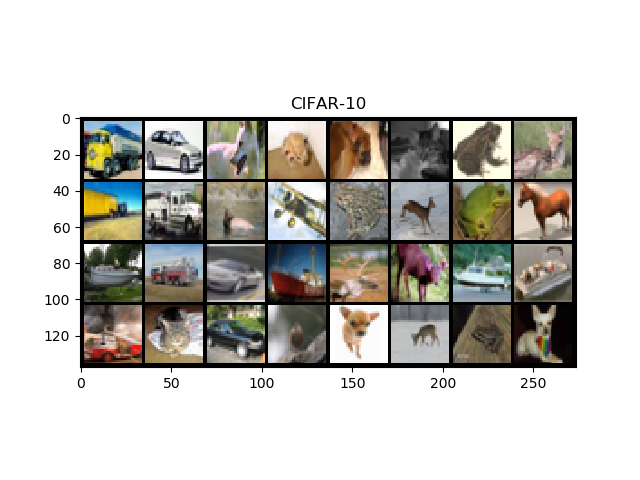

In [40]:
images, labels = iter(train_loader).next()
sample = make_grid(images, nrow=8)

plt.figure()
plt.title('CIFAR-10')
plt.imshow(np.transpose(sample.numpy(), (1, 2, 0)))
plt.show()

## Visual system model

### Retina-net

In [35]:
class RetinaNet(nn.Module):
    def __init__(self, n_bn):
        super(RetinaNet, self).__init__()
        self.n_bn = n_bn
        self.conv1 = nn.Conv2d(3, 32, 9, padding=4)
        self.conv2 = nn.Conv2d(32, n_bn, 9, padding=4)
        
    def forward(self, x):
        x = F.relu(self.conv1(x), inplace=True)
        return F.relu(self.conv2(x), inplace=True)
    
    def vis_conv1(self):
        fig = plt.figure()
        plt.title('RetinaNet conv1')
        plt.axis('off')
        conv1_w = self.conv1.weight.detach().cpu()
        conv1_w = make_grid(conv1_w, nrow=4, normalize=True)
        conv1_w = np.transpose(conv1_w.numpy(), (1, 2, 0))
        plt.imshow(conv1_w)
        plt.show()
    
    def vis_conv2(self, sample=True, sample_size=8):
        fig = plt.figure()
        plt.title('RetinaNet conv2')
        plt.axis('off')
        conv2_w = self.conv2.weight.detach().cpu()
        if sample:
            assert sample_size < 32
            plt.title('RetinaNet conv2 (sampled)')
            indices = torch.from_numpy(np.random.choice(32, sample_size, replace=False))
            conv2_w = conv2_w.index_select(1, indices)
        conv2_w = conv2_w.view(conv2_w.size(1)*self.n_bn, 1, 9, 9)
        conv2_w = make_grid(conv2_w, nrow=self.n_bn, normalize=True)
        conv2_w = np.transpose(conv2_w.numpy(), (1, 2, 0))
        plt.imshow(conv2_w)
        plt.show()
        
    def vis_activ(self, x, sample=True, sample_size=8):
        assert x.size(0) == 1  # single RGB image
        fig, (ax_x, ax_conv1, ax_conv2) = plt.subplots(1, 3)
        # visualize the input image
        ax_x.set_title('input')
        ax_x.set_axis_off()
        x_input = x.squeeze().numpy()
        x_input = np.transpose(x_input, (1, 2, 0))
        ax_x.imshow(x_input)
        # visualize activation in conv1
        ax_conv1.set_title('conv1')
        ax_conv1.set_axis_off()
        x = F.relu(self.conv1(x), inplace=True)
        x_conv1 = x.detach().cpu().squeeze().unsqueeze(1)
        if sample:
            assert sample_size < 32
            ax_conv1.set_title('conv1 (sampled)')
            indices = torch.from_numpy(np.random.choice(32, sample_size, replace=False))
            x_conv1 = x_conv1.index_select(0, indices)
        x_conv1 = make_grid(x_conv1, nrow=1, normalize=True)
        x_conv1 = np.transpose(x_conv1.numpy(), (1, 2, 0))
        ax_conv1.imshow(x_conv1)
        # visualize activation in conv2
        ax_conv2.set_title('conv2')
        ax_conv2.set_axis_off()
        x = F.relu(self.conv2(x), inplace=True)
        x_conv2 = x.detach().cpu().squeeze().unsqueeze(1)
        x_conv2 = make_grid(x_conv2, nrow=1, normalize=True)
        x_conv2 = np.transpose(x_conv2.numpy(), (1, 2, 0))
        ax_conv2.imshow(x_conv2)
        plt.show()

In [28]:
summary(RetinaNet(10), (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]           7,808
            Conv2d-2           [-1, 10, 32, 32]          25,930
Total params: 33,738
Trainable params: 33,738
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.33
Params size (MB): 0.13
Estimated Total Size (MB): 0.47
----------------------------------------------------------------


<IPython.core.display.Javascript object>


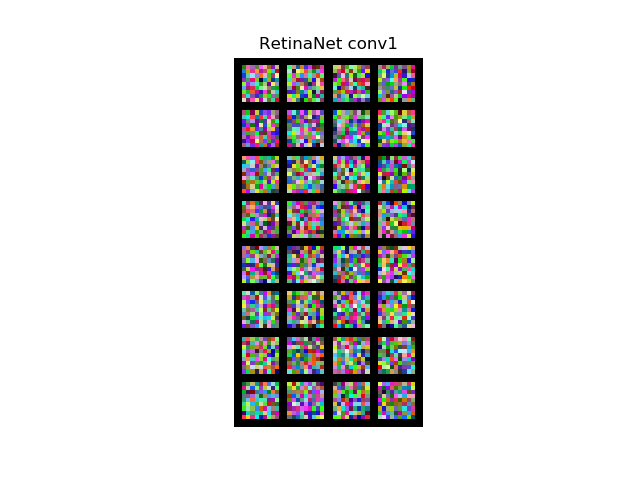

In [29]:
RetinaNet(4).vis_conv1()

<IPython.core.display.Javascript object>


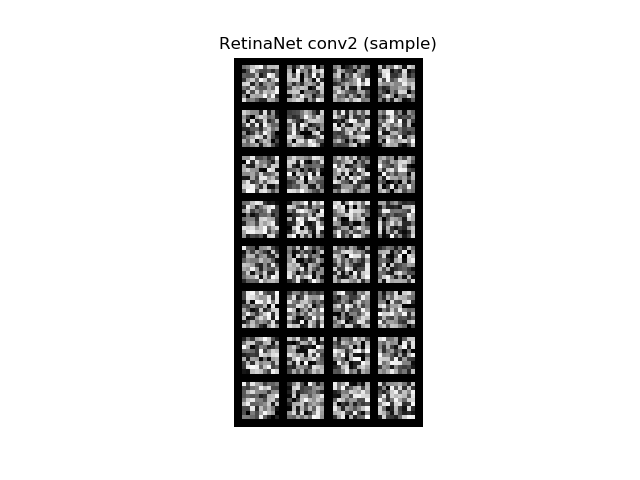

In [30]:
RetinaNet(4).vis_conv2(sample=True)

<IPython.core.display.Javascript object>


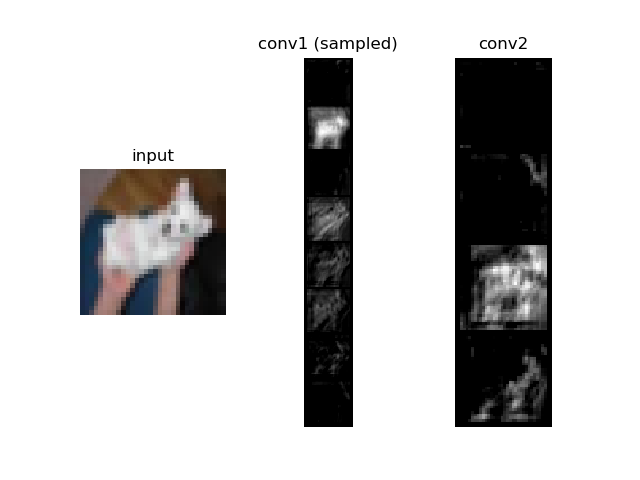

In [39]:
x, _ = iter(train_loader).next()
RetinaNet(4).vis_activ(x[0].unsqueeze(0))

### VVS-net (Ventral visual system network)

In [14]:
class VvsNet(nn.Module):
    def __init__(self, n_bn, d_vvs):
        super(VvsNet, self).__init__()
        self.d_vvs = d_vvs
        self.conv1 = nn.Conv2d(n_bn, 32, 9, padding=4)
        for i in range(1, d_vvs):
            setattr(self, f'conv{i+1}', nn.Conv2d(32, 32, 9, padding=4))
        setattr(self, f'fc{d_vvs+1}', nn.Linear(32*1024, 1024))
        self.classifier = nn.Linear(1024, 10)

    def forward(self, x):
        for i in range(self.d_vvs):
            conv = getattr(self, f'conv{i+1}')
            x = F.relu(conv(x), inplace=True)
        x = x.view(x.size(0), -1)
        fc = getattr(self, f'fc{self.d_vvs+1}')
        x = F.relu(fc(x), inplace=True)
        return F.softmax(self.classifier(x), dim=1)

In [15]:
summary(VvsNet(10, 3), (10, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]          25,952
            Conv2d-2           [-1, 32, 32, 32]          82,976
            Conv2d-3           [-1, 32, 32, 32]          82,976
            Linear-4                 [-1, 1024]      33,555,456
            Linear-5                   [-1, 10]          10,250
Total params: 33,757,610
Trainable params: 33,757,610
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.04
Forward/backward pass size (MB): 0.76
Params size (MB): 128.78
Estimated Total Size (MB): 129.57
----------------------------------------------------------------


### Combined model

In [16]:
class RetinaVvsNet(nn.Module):
    def __init__(self, n_bn, d_vvs):
        super(RetinaVvsNet, self).__init__()
        self.retina = RetinaNet(n_bn)
        self.vvs = VvsNet(n_bn, d_vvs)
        
    def forward(self, x):
        x = self.retina(x)
        return self.vvs(x)

In [17]:
summary(RetinaVvsNet(16, 4), (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]           7,808
            Conv2d-2           [-1, 16, 32, 32]          41,488
         RetinaNet-3           [-1, 16, 32, 32]               0
            Conv2d-4           [-1, 32, 32, 32]          41,504
            Conv2d-5           [-1, 32, 32, 32]          82,976
            Conv2d-6           [-1, 32, 32, 32]          82,976
            Conv2d-7           [-1, 32, 32, 32]          82,976
            Linear-8                 [-1, 1024]      33,555,456
            Linear-9                   [-1, 10]          10,250
           VvsNet-10                   [-1, 10]               0
Total params: 33,905,434
Trainable params: 33,905,434
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 1.51
Params size (MB): 129.34
Est

## Experiments

Two findings from the paper to keep in mind are:
> that a **reduction in the number of neurons at the retinal output** – corresponding to a realistic physical constraint on the number of fibers in the optic nerve – **accounted simultaneously for the emergence of center-surround RFs in our model of the retina**, and for the emergence of oriented receptive fields in the primary visual relay of the brain,

and that

> given a deep visual cortex, the retinal processing emerged as **quasi-linear and retained substantial information about the visual scene**. In contrast, for a shallow cortex, the retinal processing emerged as **nonlinear and more information-lossy, but was better at extracting features relevant to the object classification task**.

In [50]:
def train(model, optimizer, train_loader, test_loader, num_epochs):
    for ep in tqdm(range(num_epochs), desc='epochs'):
        model.train()
        for i, (x, y) in enumerate(tqdm(train_loader, desc='iters.', leave=False)):
            x, y = x.to(device), y.to(device)
            y_ = model(x)

            optimizer.zero_grad()
            loss = F.cross_entropy(y_, y)
            loss.backward()
            optimizer.step()
            
            # TODO: record important stats

In [51]:
def run_experiment(n_bn, d_vvs, num_epochs=20):
    model = RetinaVvsNet(n_bn, d_vvs).to(device)
    optimizer = optim.Adam(model.parameters())
    train(model, optimizer, train_loader, test_loader, num_epochs)

In [52]:
run_experiment(4, 1)

Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/jin/anaconda3/lib/python3.6/multiprocessing/queues.py", line 240, in _feed
    send_bytes(obj)
  File "/home/jin/anaconda3/lib/python3.6/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/home/jin/anaconda3/lib/python3.6/multiprocessing/connection.py", line 404, in _send_bytes
    self._send(header + buf)
  File "/home/jin/anaconda3/lib/python3.6/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Errno 32] Broken pipe
  File "/home/jin/anaconda3/lib/python3.6/multiprocessing/queues.py", line 240, in _feed
    send_bytes(obj)
  File "/home/jin/anaconda3/lib/python3.6/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/home/jin/anaconda3/lib/python3.6/multiprocessing/connection.py", line 404, in _send_bytes
    self._send(header + buf)
  

KeyboardInterrupt: 